In [ ]:
import boto3
import pandas as pd
from datetime import datetime, timedelta
import re

# Initialize CloudWatch client
logs_client = boto3.client('logs', region_name='us-west-1')

# Set time range (last 7 days)
start_time = int((datetime.utcnow() - timedelta(days=7)).timestamp() * 1000)
end_time = int(datetime.utcnow().timestamp() * 1000)

# Initialize an empty list to collect all data
all_data = []

# Loop through site1 to site300
for site_num in range(1, 301):
    log_group_name = f'/aws/lambda/site{site_num}-lambdafunction'
    print(f"🔍 Processing log group: {log_group_name}")

    try:
        # 🚀 Handle pagination to list all log streams
        streams = []
        paginator = logs_client.get_paginator('describe_log_streams')
        print("📜 Listing log streams...")
        for page in paginator.paginate(
            logGroupName=log_group_name,
            orderBy='LastEventTime',
            descending=True
        ):
            streams.extend(page['logStreams'])

        print(f"📘 Found {len(streams)} streams in {log_group_name}")

        for stream in streams:
            log_stream_name = stream['logStreamName']
            print(f"📖 Reading events from stream: {log_stream_name}")

            next_token = None
            previous_token = None
            events = []

            while True:
                kwargs = {
                    'logGroupName': log_group_name,
                    'logStreamName': log_stream_name,
                    'startTime': start_time,
                    'endTime': end_time,
                    'startFromHead': True
                }
                if next_token:
                    kwargs['nextToken'] = next_token

                response = logs_client.get_log_events(**kwargs)
                events.extend(response['events'])

                previous_token = next_token
                next_token = response.get('nextForwardToken')

                # Exit if token doesn't change
                if not next_token or next_token == previous_token:
                    break

            # Initialize all tracking variables
            image_id = None
            event_time = None
            write_db_timestamp = None
            billed_duration = None
            function_end_timestamp = None
            lambda_function_name = log_group_name.split('/')[-1]
            cold_start = False

            for event in events:
                message = event['message']
                timestamp = datetime.utcfromtimestamp(event['timestamp'] / 1000.0)

                # Cold start detection
                if 'INIT_REPORT' in message or ('REPORT RequestId' in message and 'Init Duration' in message):
                    cold_start = True

                # Extract image ID
                if 'Image Name:' in message:
                    match = re.search(r'Image Name:\s*(.*)', message)
                    if match:
                        image_id = match.group(1).strip()

                # Extract event time
                if 'Event Time:' in message:
                    match = re.search(r'Event Time:\s*(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', message)
                    if match:
                        event_time = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S")

                # Timestamp when writing to DB
                if 'Writing to database' in message:
                    write_db_timestamp = timestamp

                # Extract billed duration
                if 'REPORT RequestId' in message and 'Billed Duration' in message:
                    match = re.search(r'Billed Duration: ([\d\.]+) ms', message)
                    if match:
                        billed_duration = float(match.group(1))

                # Latest timestamp seen
                function_end_timestamp = timestamp

            if image_id:
                print(f"✅ Found image ID: {image_id}, Event Time: {event_time}, Billed: {billed_duration} ms, Cold Start: {cold_start}")
                all_data.append({
                    'id': image_id,
                    'lambda_function_name': lambda_function_name,
                    'event_time': event_time,
                    'write_to_database_timestamp': write_db_timestamp,
                    'function_end_timestamp': function_end_timestamp,
                    'billed_duration_ms': billed_duration,
                    'cold_start': cold_start
                })

    except logs_client.exceptions.ResourceNotFoundException:
        print(f"⚠️ Log group not found for {log_group_name}, skipping.")
        continue
    except Exception as e:
        print(f"❌ Unexpected error for {log_group_name}: {e}")
        continue

# Create final merged dataframe
df = pd.DataFrame(all_data)
print("📊 DataFrame created with", len(df), "rows.")


🔍 Processing log group: /aws/lambda/site1-lambdafunction
📜 Listing log streams...
📘 Found 156 streams in /aws/lambda/site1-lambdafunction
📖 Reading events from stream: 2025/05/08/[$LATEST]3fc08580ae6c40c0bcc5e5bfa93cb25b
✅ Found image ID: image_capture_2025-05-08_17-00-00.jpg, Event Time: 2025-05-08 23:00:17, Billed: 22215.0 ms, Cold Start: True
📖 Reading events from stream: 2025/05/08/[$LATEST]ff1af21bbe9144a9b58a1eb9a7cab340
✅ Found image ID: image_capture_2025-05-08_16-00-00.jpg, Event Time: 2025-05-08 22:00:04, Billed: 16755.0 ms, Cold Start: True
📖 Reading events from stream: 2025/05/08/[$LATEST]c1b81d92f85b44c487ad551c3b2b3716
✅ Found image ID: image_capture_2025-05-08_15-00-00.jpg, Event Time: 2025-05-08 21:00:00, Billed: 22421.0 ms, Cold Start: True
📖 Reading events from stream: 2025/05/08/[$LATEST]e62610044f464c3ba1d9125f0ab5c188
✅ Found image ID: image_capture_2025-05-08_14-00-00.jpg, Event Time: 2025-05-08 20:01:08, Billed: 25966.0 ms, Cold Start: True
📖 Reading events from 

In [ ]:
df.to_csv('logsdata.csv', index=False)

In [18]:
df['event_time'] = pd.to_datetime(df['event_time'])
df['function_end_timestamp'] = pd.to_datetime(df['function_end_timestamp'])

# Calculate duration in seconds (or milliseconds if needed)
df['function_duration_sec'] = (df['function_end_timestamp'] - df['event_time']).dt.total_seconds()
# Or in milliseconds
df['function_duration_ms'] = df['function_duration_sec'] * 1000

# Preview
print(df[['id', 'event_time', 'function_end_timestamp', 'function_duration_ms']].head())

                                      id          event_time  \
0  image_capture_2025-05-01_21-00-05.jpg 2025-05-02 03:00:08   
1  image_capture_2025-05-01_21-00-04.jpg 2025-05-02 03:00:08   
2  image_capture_2025-05-01_21-00-01.jpg 2025-05-02 03:00:08   
3  image_capture_2025-05-01_21-00-06.jpg 2025-05-02 03:00:08   
4  image_capture_2025-05-01_21-00-00.jpg 2025-05-02 03:00:08   

   function_end_timestamp  function_duration_ms  
0 2025-05-02 03:00:31.691               23691.0  
1 2025-05-02 03:00:28.104               20104.0  
2 2025-05-02 03:00:36.167               28167.0  
3 2025-05-02 03:00:31.750               23750.0  
4 2025-05-02 03:00:27.879               19879.0  


In [19]:
df['concurrency'] = df['concurrency'].apply(lambda x: 300 if x == 299 else x)

In [20]:
df.concurrency.value_counts()

concurrency
300    598
250    500
200    400
150    300
100    200
50     100
20      40
1        2
Name: count, dtype: int64

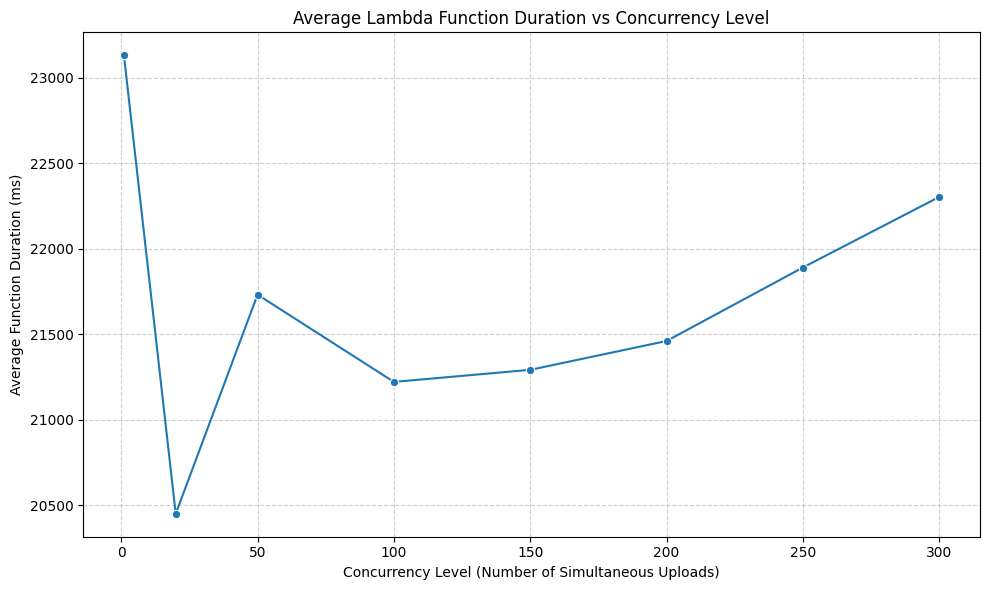

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by concurrency and compute average function duration
grouped = df.groupby('concurrency')['function_duration_ms'].mean().reset_index()

# Sort by concurrency for cleaner plot
grouped = grouped.sort_values('concurrency')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='concurrency', y='function_duration_ms', marker='o')

plt.xlabel('Concurrency Level (Number of Simultaneous Uploads)')
plt.ylabel('Average Function Duration (ms)')
plt.title('Average Lambda Function Duration vs Concurrency Level')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = df[df.cold_start==True]

# Ensure columns are numeric
df['concurrency'] = pd.to_numeric(df['concurrency'])
df['function_duration_ms'] = pd.to_numeric(df['function_duration_ms'])

# Filter only for selected concurrency levels
selected_concurrency = [1, 50, 100, 150, 200, 250, 300]
df_filtered = df[df['concurrency'].isin(selected_concurrency)]

# Calculate averages
avg_durations = df_filtered.groupby('concurrency')['function_duration_ms'].mean().reset_index()

# Print the averages
print("📊 Average Function Durations (ms):")
for _, row in avg_durations.iterrows():
    print(f"Concurrency {int(row['concurrency'])}: {row['function_duration_ms']:.2f} ms")

# Set style
sns.set(style='whitegrid', context='talk')

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_filtered,
    x='concurrency',
    y='function_duration_ms',
    errorbar='sd',
    capsize=0.2,
    color='#4C72B0'
)

# # Add annotations
# for i, row in avg_durations.iterrows():
#     barplot.text(
#         i, row['function_duration_ms'] + 10,  # 10 ms above the bar
#         f"{row['function_duration_ms']:.0f} ms",
#         color='black',
#         ha='center',
#         fontsize=10,
#         fontweight='semibold'
#     )

# Labels and title
plt.xlabel('Number of Sites Running Simultaneously', fontsize=12)
plt.ylabel('Function Execution Time (ms)', fontsize=12)
plt.title('Impact of Concurrent Site Activity on Function Duration', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


KeyError: 'concurrency'

💵 Average Lambda Cost per Invocation:
Concurrency 1: $0.002236
Concurrency 50: $0.002049
Concurrency 100: $0.001998
Concurrency 150: $0.001956
Concurrency 200: $0.002021
Concurrency 250: $0.002077
Concurrency 300: $0.002114


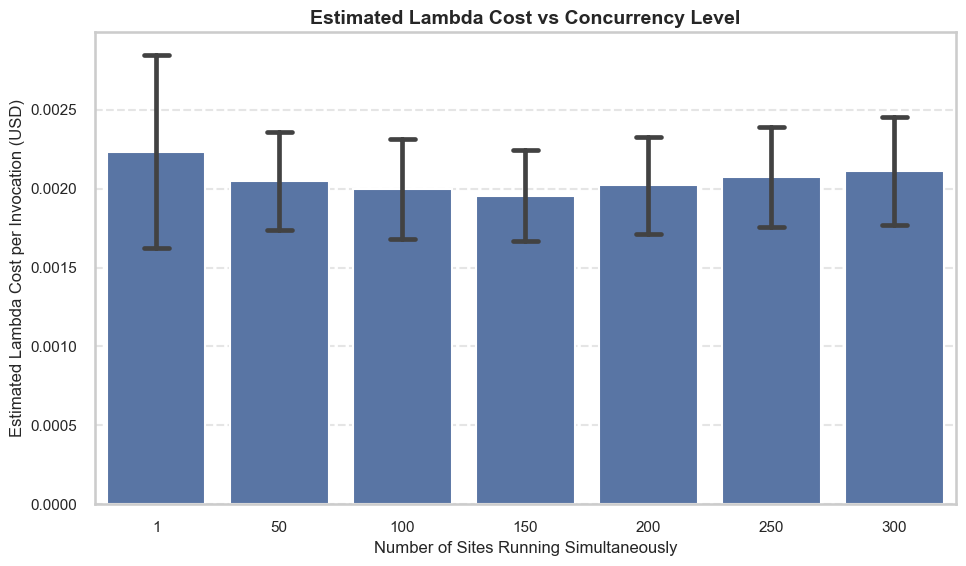

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
MEMORY_GB = 6.2
PRICE_PER_GB_SECOND = 0.0000166667

# Ensure numeric types
df['concurrency'] = pd.to_numeric(df['concurrency'])
df['billed_duration_ms'] = pd.to_numeric(df['billed_duration_ms'])

# Convert billed duration to cost
df['lambda_cost'] = (df['billed_duration_ms'] / 1000) * MEMORY_GB * PRICE_PER_GB_SECOND

# Filter for specific concurrency levels
selected_concurrency = [1, 50, 100, 150, 200, 250, 300]
df_filtered = df[df['concurrency'].isin(selected_concurrency)]

# Calculate average cost per concurrency level
avg_cost = df_filtered.groupby('concurrency')['lambda_cost'].mean().reset_index()

# Print cost summary
print("💵 Average Lambda Cost per Invocation:")
for _, row in avg_cost.iterrows():
    print(f"Concurrency {int(row['concurrency'])}: ${row['lambda_cost']:.6f}")

# Set style
sns.set(style='whitegrid', context='talk')

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_filtered,
    x='concurrency',
    y='lambda_cost',
    errorbar='sd',
    capsize=0.2,
    color='#4C72B0'
)

# Axis labels and title
plt.xlabel('Number of Sites Running Simultaneously', fontsize=12)
plt.ylabel('Estimated Lambda Cost per Invocation (USD)', fontsize=12)
plt.title('Estimated Lambda Cost vs Concurrency Level', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [46]:
df.describe()

,event_time,write_to_database_timestamp,function_end_timestamp,billed_duration_ms,concurrency,upload_group,image_timestamp,function_duration_sec,function_duration_ms
count,2140,2140,2140,2140.000000,2140.000000,2140.000000,2140,2140.000000,2140.000000
mean,2025-05-02 10:56:06.467289600,2025-05-02 10:56:27.203274752,2025-05-02 10:56:28.212975360,19830.228505,212.431776,7.402804,2025-05-02 04:55:42.198130944,21.745686,21745.685514
min,2025-05-02 03:00:08,2025-05-02 03:00:25.769000,2025-05-02 03:00:25.845000,14385.000000,1.000000,0.000000,2025-05-01 21:00:00,15.487000,15487.000000
25%,2025-05-02 07:00:52,2025-05-02 07:01:09.766500096,2025-05-02 07:01:09.824000,17312.500000,150.000000,4.000000,2025-05-02 01:00:10,19.213000,19213.000000
50%,2025-05-02 11:30:10.500000,2025-05-02 11:30:32.844499968,2025-05-02 11:30:32.949999872,19342.500000,250.000000,7.500000,2025-05-02 05:30:05.500000,21.225000,21225.000000
75%,2025-05-02 16:00:53,2025-05-02 16:01:12.045249792,2025-05-02 16:01:12.411250176,21724.000000,299.000000,12.000000,2025-05-02 10:00:04,23.609250,23609.250000
max,2025-05-02 20:00:03,2025-05-02 20:00:30.953000,2025-05-02 20:00:31.010000,34829.000000,299.000000,15.000000,2025-05-02 14:00:02,36.775000,36775.000000
std,NaN,NaN,NaN,3122.739033,78.423769,4.294162,NaN,3.213586,3213.585842


In [44]:
df[df.concurrency==299]

,id,lambda_function_name,event_time,write_to_database_timestamp,function_end_timestamp,billed_duration_ms,cold_start,concurrency,upload_group,image_timestamp,site_id,function_duration_sec,function_duration_ms
750,image_capture_2025-05-02_02-00-00.jpg,site4-lambdafunction,2025-05-02 08:01:00,2025-05-02 08:01:20.612,2025-05-02 08:01:20.657,18576.0,True,299,5,2025-05-02 02:00:00,site4,20.657,20657.0
751,image_capture_2025-05-02_02-00-08.jpg,site13-lambdafunction,2025-05-02 08:01:00,2025-05-02 08:01:25.288,2025-05-02 08:01:25.705,23611.0,True,299,5,2025-05-02 02:00:08,site13,25.705,25705.0
752,image_capture_2025-05-02_02-00-08.jpg,site16-lambdafunction,2025-05-02 08:01:00,2025-05-02 08:01:20.338,2025-05-02 08:01:20.393,18248.0,True,299,5,2025-05-02 02:00:08,site16,20.393,20393.0
753,image_capture_2025-05-02_02-00-00.jpg,site7-lambdafunction,2025-05-02 08:01:00,2025-05-02 08:01:20.910,2025-05-02 08:01:21.012,18849.0,True,299,5,2025-05-02 02:00:00,site7,21.012,21012.0
754,image_capture_2025-05-02_02-00-00.jpg,site3-lambdafunction,2025-05-02 08:01:00,2025-05-02 08:01:16.913,2025-05-02 08:01:17.001,14895.0,True,299,5,2025-05-02 02:00:00,site3,17.001,17001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,image_capture_2025-05-02_11-00-43.jpg,site206-lambdafunction,2025-05-02 17:01:08,2025-05-02 17:01:32.224,2025-05-02 17:01:34.990,25418.0,True,299,13,2025-05-02 11:00:43,site206,26.990,26990.0
2115,image_capture_2025-05-02_11-00-43.jpg,site207-lambdafunction,2025-05-02 17:01:08,2025-05-02 17:01:28.407,2025-05-02 17:01:31.704,22185.0,True,299,13,2025-05-02 11:00:43,site207,23.704,23704.0
2116,image_capture_2025-05-02_11-00-04.jpg,site38-lambdafunction,2025-05-02 17:01:09,2025-05-02 17:01:31.085,2025-05-02 17:01:34.990,24286.0,True,299,13,2025-05-02 11:00:04,site38,25.990,25990.0
2117,image_capture_2025-05-02_11-00-25.jpg,site115-lambdafunction,2025-05-02 17:01:10,2025-05-02 17:01:37.129,2025-05-02 17:01:37.177,25952.0,True,299,13,2025-05-02 11:00:25,site115,27.177,27177.0


In [41]:
df

,id,lambda_function_name,event_time,write_to_database_timestamp,function_end_timestamp,billed_duration_ms,cold_start,concurrency,upload_group,image_timestamp,site_id,function_duration_sec,function_duration_ms
0,image_capture_2025-05-01_21-00-05.jpg,site38-lambdafunction,2025-05-02 03:00:08,2025-05-02 03:00:31.639,2025-05-02 03:00:31.691,21667.0,True,50,0,2025-05-01 21:00:05,site38,23.691,23691.0
1,image_capture_2025-05-01_21-00-04.jpg,site33-lambdafunction,2025-05-02 03:00:08,2025-05-02 03:00:28.043,2025-05-02 03:00:28.104,18164.0,True,50,0,2025-05-01 21:00:04,site33,20.104,20104.0
2,image_capture_2025-05-01_21-00-01.jpg,site16-lambdafunction,2025-05-02 03:00:08,2025-05-02 03:00:36.119,2025-05-02 03:00:36.167,26184.0,True,50,0,2025-05-01 21:00:01,site16,28.167,28167.0
3,image_capture_2025-05-01_21-00-06.jpg,site44-lambdafunction,2025-05-02 03:00:08,2025-05-02 03:00:31.690,2025-05-02 03:00:31.750,21785.0,True,50,0,2025-05-01 21:00:06,site44,23.750,23750.0
4,image_capture_2025-05-01_21-00-00.jpg,site4-lambdafunction,2025-05-02 03:00:08,2025-05-02 03:00:27.833,2025-05-02 03:00:27.879,18087.0,True,50,0,2025-05-01 21:00:00,site4,19.879,19879.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,image_capture_2025-05-02_14-00-01.jpg,site12-lambdafunction,2025-05-02 20:00:03,2025-05-02 20:00:21.292,2025-05-02 20:00:21.407,16760.0,True,20,15,2025-05-02 14:00:01,site12,18.407,18407.0
2136,image_capture_2025-05-02_14-00-02.jpg,site16-lambdafunction,2025-05-02 20:00:03,2025-05-02 20:00:21.994,2025-05-02 20:00:22.216,17542.0,True,20,15,2025-05-02 14:00:02,site16,19.216,19216.0
2137,image_capture_2025-05-02_14-00-00.jpg,site2-lambdafunction,2025-05-02 20:00:03,2025-05-02 20:00:22.625,2025-05-02 20:00:22.802,18201.0,True,20,15,2025-05-02 14:00:00,site2,19.802,19802.0
2138,image_capture_2025-05-02_14-00-00.jpg,site4-lambdafunction,2025-05-02 20:00:03,2025-05-02 20:00:21.496,2025-05-02 20:00:21.553,16899.0,True,20,15,2025-05-02 14:00:00,site4,18.553,18553.0


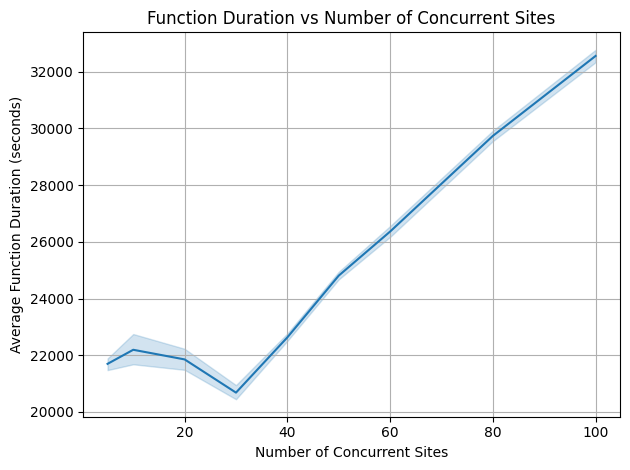

In [194]:
sns.lineplot(data=merged_df[merged_df.cold_start==True], x='no_of_sites_running_simultaneously', y='billed_duration_ms')

# Labels
plt.xlabel('Number of Concurrent Sites')
plt.ylabel('Average Function Duration (seconds)')
plt.title('Function Duration vs Number of Concurrent Sites')

# Optional: improve layout
plt.grid(True)
plt.tight_layout()

plt.show()

In [171]:
merged_df

,id,lambda_function_name,write_to_database_timestamp,function_end_timestamp,billed_duration_ms,cold_start,image_timestamp,site_id,unique_key,image_path,...,segmentation_verification,original_image_url,segmented_image_url,cycle,timediff,no_of_sites_running_simultaneously,site_number,function_duration_sec,write_lag_sec,error_lag_sec
0,image_capture_2025-04-27_20-00-00.jpg,site1-lambdafunction,2025-04-28 02:01:00.680,2025-04-28 02:01:00.715,28456.0,True,2025-04-27 20:00:00,site1,site1_2025-04-27 20:00:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,211,39.0,100,1,39.715,0.035,0.680
1,image_capture_2025-04-27_19-30-00.jpg,site1-lambdafunction,2025-04-28 01:30:55.451,2025-04-28 01:30:55.491,26618.0,True,2025-04-27 19:30:00,site1,site1_2025-04-27 19:30:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,210,38.0,80,1,38.491,0.040,0.451
2,image_capture_2025-04-27_19-00-00.jpg,site1-lambdafunction,2025-04-28 01:00:47.575,2025-04-28 01:00:47.616,23888.0,True,2025-04-27 19:00:00,site1,site1_2025-04-27 19:00:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,209,35.0,60,1,35.616,0.041,0.575
3,image_capture_2025-04-27_18-30-00.jpg,site1-lambdafunction,2025-04-28 00:30:38.940,2025-04-28 00:30:38.976,19453.0,True,2025-04-27 18:30:00,site1,site1_2025-04-27 18:30:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,208,31.0,40,1,31.976,0.036,0.940
4,image_capture_2025-04-27_18-00-00.jpg,site1-lambdafunction,2025-04-28 00:00:36.591,2025-04-28 00:00:36.646,21298.0,True,2025-04-27 18:00:00,site1,site1_2025-04-27 18:00:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,207,33.0,20,1,33.646,0.055,0.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6910,image_capture_2025-04-26_20-00-19.jpg,site100-lambdafunction,2025-04-27 02:01:06.053,2025-04-27 02:01:06.118,33320.0,True,2025-04-26 20:00:19,site100,site100_2025-04-26 20:00:19,site100-simulatedbucket/2025/April/image_captu...,...,True,https://site100-simulatedbucket.s3.amazonaws.c...,https://site100-segmentedoutput.s3.amazonaws.c...,169,45.0,100,100,45.118,0.065,0.053
6911,image_capture_2025-04-26_16-00-20.jpg,site100-lambdafunction,2025-04-26 22:01:02.644,2025-04-26 22:01:02.723,29898.0,True,2025-04-26 16:00:20,site100,site100_2025-04-26 16:00:20,site100-simulatedbucket/2025/April/image_captu...,...,True,https://site100-simulatedbucket.s3.amazonaws.c...,https://site100-segmentedoutput.s3.amazonaws.c...,162,41.0,100,100,41.723,0.079,0.644
6912,image_capture_2025-04-26_12-00-19.jpg,site100-lambdafunction,2025-04-26 18:01:04.455,2025-04-26 18:01:04.500,31439.0,True,2025-04-26 12:00:19,site100,site100_2025-04-26 12:00:19,site100-simulatedbucket/2025/April/image_captu...,...,True,https://site100-simulatedbucket.s3.amazonaws.c...,https://site100-segmentedoutput.s3.amazonaws.c...,155,43.0,100,100,43.500,0.045,0.455
6913,image_capture_2025-04-26_00-30-19.jpg,site100-lambdafunction,2025-04-26 06:31:05.534,2025-04-26 06:31:05.784,33202.0,True,2025-04-26 00:30:19,site100,site100_2025-04-26 00:30:19,site100-simulatedbucket/2025/April/image_captu...,...,True,https://site100-simulatedbucket.s3.amazonaws.c...,https://site100-segmentedoutput.s3.amazonaws.c...,144,44.0,100,100,44.784,0.250,0.534


In [176]:
merged_df.cold_start.value_counts()

cold_start
True     5144
False    1771
Name: count, dtype: int64

In [183]:
merged_df[merged_df.cold_start==True].no_of_sites_running_simultaneously.value_counts()

no_of_sites_running_simultaneously
40     1119
100    1100
50     1029
80      878
60      711
30      192
20       73
10       31
5        11
Name: count, dtype: int64

In [186]:
merged_df

,id,lambda_function_name,write_to_database_timestamp,function_end_timestamp,billed_duration_ms,cold_start,image_timestamp,site_id,unique_key,image_path,...,segmentation_verification,original_image_url,segmented_image_url,cycle,timediff,no_of_sites_running_simultaneously,site_number,function_duration_sec,write_lag_sec,error_lag_sec
0,image_capture_2025-04-27_20-00-00.jpg,site1-lambdafunction,2025-04-28 02:01:00.680,2025-04-28 02:01:00.715,28456.0,True,2025-04-27 20:00:00,site1,site1_2025-04-27 20:00:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,211,39.0,100,1,39.715,0.035,0.680
1,image_capture_2025-04-27_19-30-00.jpg,site1-lambdafunction,2025-04-28 01:30:55.451,2025-04-28 01:30:55.491,26618.0,True,2025-04-27 19:30:00,site1,site1_2025-04-27 19:30:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,210,38.0,80,1,38.491,0.040,0.451
2,image_capture_2025-04-27_19-00-00.jpg,site1-lambdafunction,2025-04-28 01:00:47.575,2025-04-28 01:00:47.616,23888.0,True,2025-04-27 19:00:00,site1,site1_2025-04-27 19:00:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,209,35.0,60,1,35.616,0.041,0.575
3,image_capture_2025-04-27_18-30-00.jpg,site1-lambdafunction,2025-04-28 00:30:38.940,2025-04-28 00:30:38.976,19453.0,True,2025-04-27 18:30:00,site1,site1_2025-04-27 18:30:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,208,31.0,40,1,31.976,0.036,0.940
4,image_capture_2025-04-27_18-00-00.jpg,site1-lambdafunction,2025-04-28 00:00:36.591,2025-04-28 00:00:36.646,21298.0,True,2025-04-27 18:00:00,site1,site1_2025-04-27 18:00:00,site1-simulatedbucket/2025/April/image_capture...,...,True,https://site1-simulatedbucket.s3.amazonaws.com...,https://site1-segmentedoutput.s3.amazonaws.com...,207,33.0,20,1,33.646,0.055,0.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6910,image_capture_2025-04-26_20-00-19.jpg,site100-lambdafunction,2025-04-27 02:01:06.053,2025-04-27 02:01:06.118,33320.0,True,2025-04-26 20:00:19,site100,site100_2025-04-26 20:00:19,site100-simulatedbucket/2025/April/image_captu...,...,True,https://site100-simulatedbucket.s3.amazonaws.c...,https://site100-segmentedoutput.s3.amazonaws.c...,169,45.0,100,100,45.118,0.065,0.053
6911,image_capture_2025-04-26_16-00-20.jpg,site100-lambdafunction,2025-04-26 22:01:02.644,2025-04-26 22:01:02.723,29898.0,True,2025-04-26 16:00:20,site100,site100_2025-04-26 16:00:20,site100-simulatedbucket/2025/April/image_captu...,...,True,https://site100-simulatedbucket.s3.amazonaws.c...,https://site100-segmentedoutput.s3.amazonaws.c...,162,41.0,100,100,41.723,0.079,0.644
6912,image_capture_2025-04-26_12-00-19.jpg,site100-lambdafunction,2025-04-26 18:01:04.455,2025-04-26 18:01:04.500,31439.0,True,2025-04-26 12:00:19,site100,site100_2025-04-26 12:00:19,site100-simulatedbucket/2025/April/image_captu...,...,True,https://site100-simulatedbucket.s3.amazonaws.c...,https://site100-segmentedoutput.s3.amazonaws.c...,155,43.0,100,100,43.500,0.045,0.455
6913,image_capture_2025-04-26_00-30-19.jpg,site100-lambdafunction,2025-04-26 06:31:05.534,2025-04-26 06:31:05.784,33202.0,True,2025-04-26 00:30:19,site100,site100_2025-04-26 00:30:19,site100-simulatedbucket/2025/April/image_captu...,...,True,https://site100-simulatedbucket.s3.amazonaws.c...,https://site100-segmentedoutput.s3.amazonaws.c...,144,44.0,100,100,44.784,0.250,0.534


In [12]:
df.cold_start==False

0        False
1        False
2        False
3        False
4        False
         ...  
19691    False
19692    False
19693    False
19694    False
19695    False
Name: cold_start, Length: 19696, dtype: bool